In [139]:
import networkx as nx
import random
import block_division_func as bd

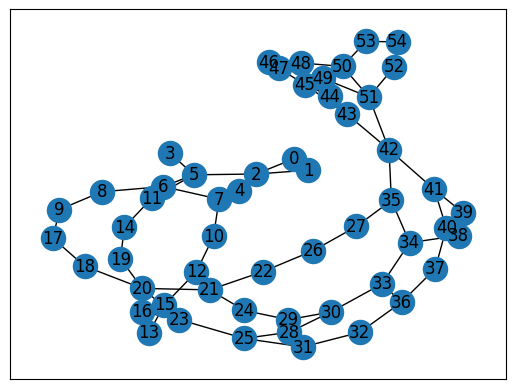

In [140]:
# GraphML形式のグラフを読み込む
G = nx.read_graphml("./data/japanese_topology.graphml")

pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos)

In [141]:
def get_random_nodes(graph, node_num: int) -> list:
    """ネットワークトポロジーからランダムにノードをn個選択する

    Args:
        graph (_type_): トポロジ
        node_num (int): 取得するノードの個数

    Returns:
        list: 取得したノード番号のリスト
    """    
    random_nodes = random.sample(list(graph.nodes()), node_num)
    random_nodes = [int(node) for node in random_nodes]
    return random_nodes

In [142]:
num_pcs = 4
num_blocks = 12

random_nodes = get_random_nodes(graph=G, node_num=num_pcs)

capacities = bd.generate_pc_capacity_list(num_pcs = num_pcs, num_blocks = num_blocks)
# 結果を表示
print(random_nodes)

[54, 12, 13, 31]
